# Setup clickhouse client

In [1]:
pip install clickhouse-connect

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import clickhouse_connect
import glob
import numpy as np
import psutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from collections import defaultdict

In [2]:
ch_host='localhost'
ch_port=8123

In [3]:
client = clickhouse_connect.get_client(host=ch_host, port=ch_port)

# Execute Queries

In [4]:
activate_optimizer_setting = " SETTINGS yannakakis_optimizer = 1, max_execution_time=50"
deactivate_optimizer_setting = " SETTINGS yannakakis_optimizer = 0, max_execution_time=50"
test_query = "SELECT * FROM system.tables"

In [5]:
# Execute Test Query with and without optimization
client.query((test_query + activate_optimizer_setting)).result_rows
client.query((test_query + deactivate_optimizer_setting)).result_rows

[('INFORMATION_SCHEMA',
  'COLUMNS',
  UUID('00000000-0000-0000-0000-000000000000'),
  'View',
  0,
  [],
  '',
  datetime.datetime(1970, 1, 1, 2, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200), 'CEST')),
  [],
  [],
  "CREATE VIEW INFORMATION_SCHEMA.COLUMNS (`table_catalog` String, `table_schema` String, `table_name` String, `column_name` String, `ordinal_position` UInt64, `column_default` String, `is_nullable` String, `data_type` String, `character_maximum_length` Nullable(UInt64), `character_octet_length` Nullable(UInt64), `numeric_precision` Nullable(UInt64), `numeric_precision_radix` Nullable(UInt64), `numeric_scale` Nullable(UInt64), `datetime_precision` Nullable(UInt64), `character_set_catalog` Nullable(String), `character_set_schema` Nullable(String), `character_set_name` Nullable(String), `collation_catalog` Nullable(String), `collation_schema` Nullable(String), `collation_name` Nullable(String), `domain_catalog` Nullable(String), `domain_schema` Nullable(String)

In [6]:
path1 = 'queries/imdb/'
path2 = 'queries/snap/'
paths = [path1, path2]

# Use glob to find all files with a .sql extension in the specified directory
sql_files = []
for path in paths:
    sql_files.extend(glob.glob(path + '*.sql'))
queries = []

# Loop through each SQL file and read its contents
for sql_file in sql_files:
    with open(sql_file, 'r') as file:
        queries.append([file.read(), sql_file])

In [7]:
# key = filename
# value = [elapsed_time, memory, query_result, optimizer_used, run_number]
results = defaultdict(list)

excluded = []
runs = 5

In [8]:
def run_queries(number_of_runs, queries, query_settings):
    for i in range(number_of_runs):
        for query, filename in queries:
            if any(excluded_file in filename for excluded_file in excluded):
                continue
            print(i, filename)
            start_time = time.time()
            initial_memory = psutil.virtual_memory().used

            try:
                result = client.query(query + query_settings)
            except Exception as e:
                print(f"Query execution failed for {filename}: {e}")
                results[filename].append([-1, -1, "TIMEOUT_EXCEEDED", query_settings, i])
                continue
                
            end_time = time.time()
            elapsed_time = end_time - start_time
            final_memory = psutil.virtual_memory().used
            peak_memory = max(initial_memory, final_memory) >> 20 # convert to MB
            results[filename].append([elapsed_time, peak_memory, result.result_rows, query_settings, i])

## Run with optimizer

In [9]:
run_queries(runs, queries, activate_optimizer_setting)

0 queries/imdb/q2d.sql
0 queries/imdb/20a.sql
0 queries/imdb/q2c.sql
0 queries/imdb/3b.sql
0 queries/imdb/q5b.sql
0 queries/imdb/17d.sql
0 queries/imdb/3a.sql
0 queries/imdb/q5a.sql
0 queries/imdb/17e.sql
0 queries/imdb/q2a.sql
0 queries/imdb/17a.sql
0 queries/imdb/20b.sql
0 queries/imdb/q2b.sql
0 queries/imdb/17c.sql
0 queries/imdb/3c.sql
0 queries/imdb/17b.sql
0 queries/imdb/q5c.sql
0 queries/snap/patents-path04.sql
0 queries/snap/patents-path05.sql
0 queries/snap/patents-path02.sql
0 queries/snap/patents-path03.sql
1 queries/imdb/q2d.sql
1 queries/imdb/20a.sql
1 queries/imdb/q2c.sql
1 queries/imdb/3b.sql
1 queries/imdb/q5b.sql
1 queries/imdb/17d.sql
1 queries/imdb/3a.sql
1 queries/imdb/q5a.sql
1 queries/imdb/17e.sql
1 queries/imdb/q2a.sql
1 queries/imdb/17a.sql
1 queries/imdb/20b.sql
1 queries/imdb/q2b.sql
1 queries/imdb/17c.sql
1 queries/imdb/3c.sql
1 queries/imdb/17b.sql
1 queries/imdb/q5c.sql
1 queries/snap/patents-path04.sql
1 queries/snap/patents-path05.sql
1 queries/snap/paten

## Run without optimizer

In [10]:
run_queries(runs, queries, deactivate_optimizer_setting)

0 queries/imdb/q2d.sql
0 queries/imdb/20a.sql
0 queries/imdb/q2c.sql
0 queries/imdb/3b.sql
0 queries/imdb/q5b.sql
0 queries/imdb/17d.sql
Query execution failed for queries/imdb/17d.sql: :HTTPDriver for http://localhost:8123 returned response code 408)
 Code: 159. DB::Exception: Timeout exceeded: elapsed 50.007257733 seconds, maximum: 50. (TIMEOUT_EXCEEDED) (version 23.9.1.1)

0 queries/imdb/3a.sql
0 queries/imdb/q5a.sql
0 queries/imdb/17e.sql
Query execution failed for queries/imdb/17e.sql: :HTTPDriver for http://localhost:8123 returned response code 408)
 Code: 159. DB::Exception: Timeout exceeded: elapsed 50.006900031 seconds, maximum: 50. (TIMEOUT_EXCEEDED) (version 23.9.1.1)

0 queries/imdb/q2a.sql
0 queries/imdb/17a.sql
Query execution failed for queries/imdb/17a.sql: :HTTPDriver for http://localhost:8123 returned response code 408)
 Code: 159. DB::Exception: Timeout exceeded: elapsed 50.00781177 seconds, maximum: 50. (TIMEOUT_EXCEEDED) (version 23.9.1.1)

0 queries/imdb/20b.sql
0

3 queries/snap/patents-path04.sql
Query execution failed for queries/snap/patents-path04.sql: :HTTPDriver for http://localhost:8123 returned response code 408)
 Code: 159. DB::Exception: Timeout exceeded: elapsed 51.216383793 seconds, maximum: 50. (TIMEOUT_EXCEEDED) (version 23.9.1.1)

3 queries/snap/patents-path05.sql
Query execution failed for queries/snap/patents-path05.sql: :HTTPDriver for http://localhost:8123 returned response code 408)
 Code: 159. DB::Exception: Timeout exceeded: elapsed 50.956348637 seconds, maximum: 50. (TIMEOUT_EXCEEDED) (version 23.9.1.1)

3 queries/snap/patents-path02.sql
3 queries/snap/patents-path03.sql
4 queries/imdb/q2d.sql
4 queries/imdb/20a.sql
4 queries/imdb/q2c.sql
4 queries/imdb/3b.sql
4 queries/imdb/q5b.sql
4 queries/imdb/17d.sql
Query execution failed for queries/imdb/17d.sql: :HTTPDriver for http://localhost:8123 returned response code 408)
 Code: 159. DB::Exception: Timeout exceeded: elapsed 50.006826225 seconds, maximum: 50. (TIMEOUT_EXCEEDED)

In [11]:
benchmark_results = {}
for filename, result_objects in results.items():
    _, dataset, query_name = filename.split("/")
    for result_object in result_objects: #result_object = [elapsed_time, memory, query_result, optimizer_used, run_number]
        elapsed_time, memory, query_result, optimizer_used, run_number = result_object
        if activate_optimizer_setting in optimizer_used:
            optimizer = True
        else:
            optimizer = False
        benchmark_results[(dataset,query_name,run_number,optimizer)] = result_object
print(benchmark_results)

{('imdb', 'q2d.sql', 0, True): [2.5677504539489746, 9705, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 1, max_execution_time=50', 0], ('imdb', 'q2d.sql', 1, True): [3.5550408363342285, 6128, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 1, max_execution_time=50', 1], ('imdb', 'q2d.sql', 2, True): [2.8763656616210938, 6308, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 1, max_execution_time=50', 2], ('imdb', 'q2d.sql', 3, True): [3.535714626312256, 6354, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 1, max_execution_time=50', 3], ('imdb', 'q2d.sql', 4, True): [3.578768491744995, 6454, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 1, max_execution_time=50', 4], ('imdb', 'q2d.sql', 0, False): [4.533439874649048, 8426, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 0, max_execution_time=50', 0], ('imdb', 'q2d.sql', 1, False): [5.23299503326416, 7756, [('& Teller',)], ' SETTINGS yannakakis_optimizer = 0, max_execution_time=50', 1], ('imdb', 'q2d.sql', 2, False)

# Tables

In [14]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

In [39]:
df = pd.DataFrame([[k[0],k[1],k[2],k[3],v[0],v[1]] for k,v in benchmark_results.items()]) \
           .rename(columns={0:'Dataset',1:'Query',2:'Run Number',3:'Optimizer Used', 4:'Runtime (s)', 5:'Memory Usage (MB)'})
df

,Dataset,Query,Run Number,Optimizer Used,Runtime (s),Memory Usage (MB)
0,imdb,q2d.sql,0,True,2.567750,9705
1,imdb,q2d.sql,1,True,3.555041,6128
2,imdb,q2d.sql,2,True,2.876366,6308
3,imdb,q2d.sql,3,True,3.535715,6354
4,imdb,q2d.sql,4,True,3.578768,6454
5,imdb,q2d.sql,0,False,4.533440,8426
6,imdb,q2d.sql,1,False,5.232995,7756
7,imdb,q2d.sql,2,False,5.266980,8062
8,imdb,q2d.sql,3,False,5.320233,8488
9,imdb,q2d.sql,4,False,4.681564,7576


## Runtime Table Overview

In [73]:
# Calculate average runtime with and without optimizer
runtime_df = df.groupby(['Dataset', 'Query']).apply(lambda x: pd.Series({
    'Base Mean': x[x['Optimizer Used'] == False]['Runtime (s)'].mean(),
    'Base SD': x[x['Optimizer Used'] == False]['Runtime (s)'].std(),
    'With Optimizer Mean (s)': x[x['Optimizer Used'] == True]['Runtime (s)'].mean(),
    'With Optimizer SD (s)': x[x['Optimizer Used'] == True]['Runtime (s)'].std()
})).reset_index()

# Compute absolute difference between runtime with and without optimizer
runtime_df['Difference Runtime'] = runtime_df['With Optimizer Mean (s)']-runtime_df['Base Mean']

# Replace -1 (timeouts) with "Terminated"
runtime_df.replace(-1, float('nan'), inplace=True)

# Update columns to show mean ± SD
runtime_df['Without Optimizer'] = runtime_df.apply(
    lambda row: f"{row['Base Mean']:.2f} ± {row['Base SD']:.2f} s" if pd.notna(row['Base Mean']) else 'timeout', axis=1
)
runtime_df['With Optimizer'] = runtime_df.apply(
    lambda row: f"{row['With Optimizer Mean (s)']:.2f} ± {row['With Optimizer SD (s)']:.2f} s" if pd.notna(row['With Optimizer Mean (s)']) else 'timeout', axis=1
)

# Replace difference Runtime with '-' in case of a timeout
runtime_df['Difference Runtime'] = runtime_df.apply(
    lambda row: '-' if row['Without Optimizer'] == 'timeout' else f"{row['Difference Runtime']:.2f} s", axis=1
)

# Select relevant columns
runtime_df_table = runtime_df[['Dataset', 'Query', 'Without Optimizer', 'With Optimizer', 'Difference Runtime']]

print("Summary for Runtime:")
runtime_df_table

Summary for Runtime:


,Dataset,Query,Without Optimizer,With Optimizer,Difference Runtime
0,imdb,17a.sql,timeout,14.95 ± 2.07 s,-
1,imdb,17b.sql,timeout,15.20 ± 1.58 s,-
2,imdb,17c.sql,timeout,15.77 ± 2.45 s,-
3,imdb,17d.sql,timeout,15.07 ± 2.27 s,-
4,imdb,17e.sql,timeout,15.30 ± 1.97 s,-
5,imdb,20a.sql,22.57 ± 0.67 s,18.42 ± 2.55 s,-4.14 s
6,imdb,20b.sql,19.59 ± 1.16 s,16.86 ± 2.18 s,-2.74 s
7,imdb,3a.sql,5.19 ± 0.48 s,3.77 ± 0.60 s,-1.42 s
8,imdb,3b.sql,3.52 ± 0.23 s,2.75 ± 0.53 s,-0.78 s
9,imdb,3c.sql,6.77 ± 0.54 s,4.05 ± 0.57 s,-2.72 s


In [54]:
print(runtime_df_table.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Dataset &              Query & Without Optimizer & With Optimizer & Difference Runtime \\
\midrule
   imdb &            17a.sql &           timeout & 14.95 ± 2.07 s &                  - \\
   imdb &            17b.sql &           timeout & 15.20 ± 1.58 s &                  - \\
   imdb &            17c.sql &           timeout & 15.77 ± 2.45 s &                  - \\
   imdb &            17d.sql &           timeout & 15.07 ± 2.27 s &                  - \\
   imdb &            17e.sql &           timeout & 15.30 ± 1.97 s &                  - \\
   imdb &            20a.sql &    22.57 ± 0.67 s & 18.42 ± 2.55 s &           -4.14181 \\
   imdb &            20b.sql &    19.59 ± 1.16 s & 16.86 ± 2.18 s &           -2.73661 \\
   imdb &             3a.sql &     5.19 ± 0.48 s &  3.77 ± 0.60 s &          -1.420542 \\
   imdb &             3b.sql &     3.52 ± 0.23 s &  2.75 ± 0.53 s &          -0.776138 \\
   imdb &             3c.sql &     6.77 ± 0.54 s &  4.05 ± 

## Memory Usage Overview

In [69]:
# Calculate average runtime with and without optimizer
memory_df = df.groupby(['Dataset', 'Query']).apply(lambda x: pd.Series({
    'Base Mean': x[x['Optimizer Used'] == False]['Memory Usage (MB)'].mean(),
    'Base SD': x[x['Optimizer Used'] == False]['Memory Usage (MB)'].std(),
    'With Optimizer Mean': x[x['Optimizer Used'] == True]['Memory Usage (MB)'].mean(),
    'With Optimizer SD': x[x['Optimizer Used'] == True]['Memory Usage (MB)'].std()
})).reset_index()

memory_df['Difference Memory'] = memory_df['With Optimizer Mean']-memory_df['Base Mean']

# Replace -1 (timeouts) with "Terminated"
memory_df.replace(-1, float('nan'), inplace=True)

# Update columns to show mean ± SD
memory_df['Without Optimizer'] = memory_df.apply(
    lambda row: f"{row['Base Mean']:.0f} ± {row['Base SD']:.2f} MB" if pd.notna(row['Base Mean']) else 'timeout', axis=1
)
memory_df['With Optimizer'] = memory_df.apply(
    lambda row: f"{row['With Optimizer Mean']:.0f} ± {row['With Optimizer SD']:.0f} MB" if pd.notna(row['With Optimizer Mean']) else 'timeout', axis=1
)

# Replace difference Runtime with '-' in case of a timeout
memory_df['Difference Memory'] = memory_df.apply(
    lambda row: '-' if row['Without Optimizer'] == 'timeout' else f"{row['Difference Memory']:.0f} MB", axis=1
)

# Select relevant columns
memory_df_table = memory_df[['Dataset', 'Query', 'Without Optimizer', 'With Optimizer', 'Difference Memory']]

print("Summary for Runtime:")
memory_df_table

Summary for Runtime:


,Dataset,Query,Without Optimizer,With Optimizer,Difference Memory
0,imdb,17a.sql,timeout,6719 ± 325 MB,-
1,imdb,17b.sql,timeout,6730 ± 381 MB,-
2,imdb,17c.sql,timeout,6458 ± 252 MB,-
3,imdb,17d.sql,timeout,6542 ± 317 MB,-
4,imdb,17e.sql,timeout,6458 ± 85 MB,-
5,imdb,20a.sql,9011 ± 556.71 MB,7190 ± 1026 MB,-1821 MB
6,imdb,20b.sql,7437 ± 1026.86 MB,6716 ± 323 MB,-721 MB
7,imdb,3a.sql,6641 ± 259.83 MB,6492 ± 294 MB,-149 MB
8,imdb,3b.sql,9393 ± 435.52 MB,6403 ± 425 MB,-2991 MB
9,imdb,3c.sql,6535 ± 760.14 MB,6477 ± 256 MB,-58 MB


In [74]:
print(memory_df_table.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Dataset &              Query & Without Optimizer & With Optimizer & Difference Memory \\
\midrule
   imdb &            17a.sql &           timeout &  6719 ± 325 MB &                 - \\
   imdb &            17b.sql &           timeout &  6730 ± 381 MB &                 - \\
   imdb &            17c.sql &           timeout &  6458 ± 252 MB &                 - \\
   imdb &            17d.sql &           timeout &  6542 ± 317 MB &                 - \\
   imdb &            17e.sql &           timeout &   6458 ± 85 MB &                 - \\
   imdb &            20a.sql &  9011 ± 556.71 MB & 7190 ± 1026 MB &          -1821 MB \\
   imdb &            20b.sql & 7437 ± 1026.86 MB &  6716 ± 323 MB &           -721 MB \\
   imdb &             3a.sql &  6641 ± 259.83 MB &  6492 ± 294 MB &           -149 MB \\
   imdb &             3b.sql &  9393 ± 435.52 MB &  6403 ± 425 MB &          -2991 MB \\
   imdb &             3c.sql &  6535 ± 760.14 MB &  6477 ± 256 MB &  

# Plots

## Runtime Comparison

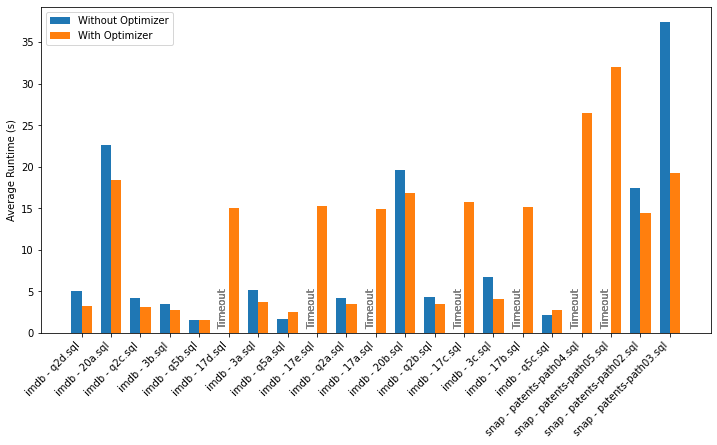

In [89]:
# Define a custom color palette
color_without_optimizer = '#1f77b4'  # Blue
color_with_optimizer = '#ff7f0e'      # Orange

grouped_data = {}
for (dataset, query, _, optimizer), (runtime, _, _, _, _) in benchmark_results.items():
    key = (dataset, query)
    if key not in grouped_data:
        grouped_data[key] = {'With Optimizer': [], 'Without Optimizer': []}
    if runtime == -1:
        runtime = 'Timeout' # Set timeout as string for y-axis
    else:
        runtime = runtime # Keep runtime as numeric if not timeout
    grouped_data[key][('With Optimizer' if optimizer else 'Without Optimizer')].append(runtime)

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35
x_pos = np.arange(len(grouped_data))

for i, (query, data) in enumerate(grouped_data.items()):
    # Extract numeric data for bars
    without_optimizer_numeric = [x for x in data['Without Optimizer'] if isinstance(x, (int, float))]
    with_optimizer_numeric = [x for x in data['With Optimizer'] if isinstance(x, (int, float))]
    
    # Plot bars only if there's numeric data
    if without_optimizer_numeric:
        ax.bar(x_pos[i] - width/2, np.mean(without_optimizer_numeric), width, label='Without Optimizer', color=color_without_optimizer)
        #ax.errorbar(x_pos[i] - width/2, np.mean(without_optimizer_numeric), yerr=np.std(without_optimizer_numeric), color='black', capsize=3)
    if with_optimizer_numeric:
        ax.bar(x_pos[i] + width/2, np.mean(with_optimizer_numeric), width, label='With Optimizer', color=color_with_optimizer)
        #ax.errorbar(x_pos[i] + width/2, np.mean(with_optimizer_numeric), yerr=np.std(with_optimizer_numeric), color='black', capsize=3)

    # Add "Timeout" text annotations
    for j, val in enumerate(data['Without Optimizer']):
        if val == 'Timeout':
            ax.text(x_pos[i] - width/2, 0.5, 'Timeout', ha='center', va='bottom', rotation=90, color='grey')
    for j, val in enumerate(data['With Optimizer']):
        if val == 'Timeout':
            ax.text(x_pos[i] + width/2, 0.5, 'Timeout', ha='center', va='bottom', rotation=90, color='grey')

ax.set_xticks(x_pos)
ax.set_xticklabels([f"{dataset} - {query}" for (dataset, query) in grouped_data.keys()], rotation=45, ha="right")
ax.set_ylabel('Average Runtime (s)')
#ax.set_title('Average Runtime Comparison with and without Optimizer')

# Show legend only once
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique)) 
#plt.tight_layout() 
plt.show()

## Memory Usage Comparison

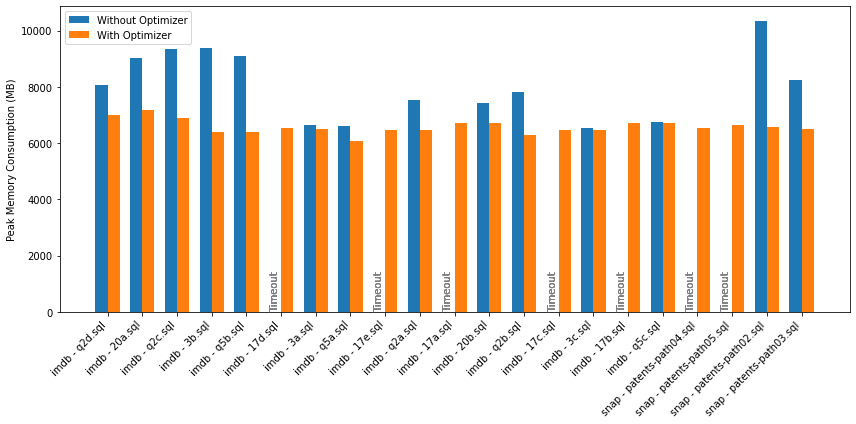

In [92]:
# Define a custom color palette
color_without_optimizer = '#1f77b4'  # Blue
color_with_optimizer = '#ff7f0e'      # Orange

grouped_data = {}
for (dataset, query, _, optimizer), (_, memory, _, _, _) in benchmark_results.items():
    key = (dataset, query)
    if key not in grouped_data:
        grouped_data[key] = {'With Optimizer': [], 'Without Optimizer': []}
    if memory == -1:
        memory = 'Timeout' # Set timeout as string for y-axis
    else:
        memory = memory 
    grouped_data[key][('With Optimizer' if optimizer else 'Without Optimizer')].append(memory)

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.35
x_pos = np.arange(len(grouped_data))

for i, (query, data) in enumerate(grouped_data.items()):
    # Extract numeric data for bars
    without_optimizer_numeric = [x for x in data['Without Optimizer'] if isinstance(x, (int, float))]
    with_optimizer_numeric = [x for x in data['With Optimizer'] if isinstance(x, (int, float))]
    
    # Plot bars only if there's numeric data
    if without_optimizer_numeric:
        ax.bar(x_pos[i] - width/2, np.mean(without_optimizer_numeric), width, label='Without Optimizer', color=color_without_optimizer)
        #ax.errorbar(x_pos[i] - width/2, np.mean(without_optimizer_numeric), yerr=np.std(without_optimizer_numeric), color='black', capsize=3)
    if with_optimizer_numeric:
        ax.bar(x_pos[i] + width/2, np.mean(with_optimizer_numeric), width, label='With Optimizer', color=color_with_optimizer)
        #ax.errorbar(x_pos[i] + width/2, np.mean(with_optimizer_numeric), yerr=np.std(with_optimizer_numeric), color='black', capsize=3)

    # Add "Timeout" text annotations
    for j, val in enumerate(data['Without Optimizer']):
        if val == 'Timeout':
            ax.text(x_pos[i] - width/2, 34, 'Timeout', ha='center', va='bottom', rotation=90, color='grey')
    for j, val in enumerate(data['With Optimizer']):
        if val == 'Timeout':
            ax.text(x_pos[i] + width/2, 34, 'Timeout', ha='center', va='bottom', rotation=90, color='grey')

ax.set_xticks(x_pos)
ax.set_xticklabels([f"{dataset} - {query}" for (dataset, query) in grouped_data.keys()], rotation=45, ha="right")
ax.set_ylabel('Peak Memory Consumption (MB)')
#ax.set_title('Average Runtime Comparison with and without Optimizer')

# Show legend only once
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique)) 
plt.tight_layout() 
plt.show()